# Introduction

In this benchmarking challenge, you will be tasked to create an [AutoRA theorist](https://autoresearch.github.io/autora/theorist/) to discover equations that best describe a given data set.

You can use this notebook to benchmark your theorist based on 3 different datasets from 3 different cogntive models, respectively.








## Benchmarking Challenge Rules

- All contributing teams must publish a pip package of their theorist. We recommend using a pre-release.
- The package name must be ``autora-theorist-yourtheorist``
- The **theorist must have a fit and predict function**, and it must be **compatible with the synthetic models** in this notebook. We will call the following code to evaluate the theorists, except that we won't be using the Weber-Fechner-Law:

```python
pip install --pre <autora-theorist-yourtheorist>

from autora.theorist.yourtheorist import yourtheorist
from autora.experiment_runner.synthetic.psychophysics.weber_fechner_law import weber_fechner_law # this will be a secret ground truth model

experiment_runner = weber_fechner_law()
theorist = yourtheorist()

# generate all conditions
conditions = experiment_runner.domain()

# generate all corresponding observations
experiment_data = experiment_runner.run(conditions, added_noise=0.01)

# get the name of the independent and independent variables
ivs = [iv.name for iv in experiment_runner.variables.independent_variables]
dvs = [dv.name for dv in experiment_runner.variables.dependent_variables]

# extract the dependent variable (observations) from experiment data
conditions = experiment_data[ivs]
observations = experiment_data[dvs]

# split into train and test datasets
conditions_train, conditions_test, observations_train, observations_test = train_test_split(conditions, observations)

# fit theorist
theorist.fit(conditions_train, observations_train)

# compute prediction for validation set
predictions = theorist.predict(conditions_test)

# evaluate theorist performance
error = (predictions - observations_test).pow(2)
error = error.mean()

theorist.print_eqn()


```

- Theorist also **must have a function ``print_eqn`` returning the discovered equation as a string.**
- The discovered equation **may not include more than 40 symbols/function elements**.
- Teams will be ranked based on the fit to two ground-truth models. Observations will be sampled across the entire domain of the ground-truth model. The rank will be accumulated across all benchmarking challenges. The team with the best accumulated rank will win a prize at the end of the workshop.
- The teams must provide a **brief presentation** (less than 5 minutes) of their theorist just before the final evaluation. You may use [this template for your slides](https://docs.google.com/presentation/d/1esmYO09ehiGOkzBsBAEf_wCfx2JrlmWwP7dyfpu0dEM/edit?usp=sharing).

*Hint: You may not use a search space including more than the following functions and operators.*
  - +
  - -
  - *
  - /
  - e^x
  - ln x
  - x^c
  - c (constants may appear)

## Grading

- Due date: **August 30**
- Submission: Through ``Stud.IP -> Tasks -> Equation Discovery Challenge``

The grading is independent of the outcome of the benchmarking challenge.

The following points will be provided:
- A demonstration of the theorist in the ``doc/Basic Usage.ipynb``:
  -  2 points: Demonstrating how to use the theorist for fitting
  -  2 points: Demonstrating how to use the theorist for predicting
  -  2 points: Demonstrating how to obtain the equation fit by the theorist
  -  4 points: Demonstrating that the theorist can recover at least two ground truth models. (*Hint: You could use the benchmarking part of the notebook below as a starting point*).
- The documentation of the theorist in ``doc/index.md`` must speak to the following information:
  - 2 points: Search Algorithm: a description of the search algorithm, and how the goodness of the equation was determined?
  - 2 points: Search Space: which search space was used and how was the search otherwise constrained?
- 2 points: The code contains at least two useful unit tests for the theorist method (either doc tests or separate tests)
- 1 point: the contributors used issues to track bugs and work on features.
- 1 point: the contributors used (helpful) code reviews for their PRs.
- 1 point: Unit tests are automatically executed when a pull request is created.
- 1 point: The documentation is hosted automatically.

Finally, teams must outline the contributions of each team member in their submission on ``Stud.IP -> Tasks -> Equation Discovery Challenge``.

In total, you can obtain 20 points.

## Additional Resources

- You can learn more about how to write AutoRA theorists in the [Contributor Guide](https://autoresearch.github.io/autora/contribute/modules/theorist/).

- You can learn more about how to use AutoRA in the [User Tutorial](https://autoresearch.github.io/autora/tutorials/).

- If you want to learn more about AutoRA states, you can check out [this tutorial on using AutoRA states](https://colab.research.google.com/drive/1yK1OBRpPZM1NgTMV9arHlE5j8xXjsGqq?usp=sharing).

# Code for Benchmarking your Theorist

## Installation

*Hint: You may want to add ``autora`` as a development dependency in your ``pyproject.tml``.*

In [2]:
%%capture
!pip install autora
!pip install autora[all-theorists]

## Imports

In [1]:
# autora state
from autora.state import StandardState, on_state, Delta

# experiment_runner
from autora.experiment_runner.synthetic.psychophysics.weber_fechner_law import weber_fechner_law
from autora.experiment_runner.synthetic.psychophysics.stevens_power_law import stevens_power_law
from autora.experiment_runner.synthetic.economics.expected_value_theory import expected_value_theory

# experimentalist
from autora.experimentalist.grid import grid_pool
from autora.experimentalist.random import random_pool, random_sample

# data handling
from sklearn.model_selection import train_test_split

# *Add src folder onto sys.path
import sys, os

# assuming your notebook lives one level above src/
HERE = os.path.dirname(os.path.abspath("__file__"))
SRC  = os.path.join(HERE, "src")
sys.path.insert(0, SRC)


## Benchmarking Function

We will use the following function for benchmarking our model for any given experiment runner.

In [2]:
def benchmark(experiment_runner, theorist):

  # generate all conditions
  conditions = experiment_runner.domain()

  # generate all corresponding observations
  experiment_data = experiment_runner.run(conditions, added_noise=0.01)

  # get the name of the independent and independent variables
  ivs = [iv.name for iv in experiment_runner.variables.independent_variables]
  dvs = [dv.name for dv in experiment_runner.variables.dependent_variables]

  # extract the dependent variable (observations) from experiment data
  conditions = experiment_data[ivs]
  observations = experiment_data[dvs]

  # split into train and test datasets
  conditions_train, conditions_test, observations_train, observations_test = train_test_split(conditions, observations)

  print("#### EXPERIMENT CONDITIONS (X):")
  print(conditions)
  print("#### EXPERIMENT OBSERVATIONS (Y):")
  print(observations)

  # fit theorist
  theorist.fit(conditions_train, observations_train)

  # compute prediction for validation set
  predictions = theorist.predict(conditions_test)

  # evaluate theorist performance
  error = (predictions - observations_test).pow(2)
  error = error.mean()

  print("#### IDENTIFIED EQUATION:")
  print(theorist.print_eqn())

  print("#### VALIDATION SET MSE:")
  print(error)

  experiment_runner.plotter(model=theorist)

  # added later on
  theorist.print_eqn()


## Dummy Theorist

For demonstration purposes, we will use this dummy theorist below. However, to effectively benchmark *your* equation discovery method, you may instead import your theorist from ``.src.theorist`` and use it instead.

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


class PolynomialRegressor:
    """
    This theorist fits a polynomial function to the data.
    """

    def __init__(self, degree: int = 3):
      self.poly = PolynomialFeatures(degree=degree, include_bias=False)
      self.model = LinearRegression()

    def fit(self, x, y):
      features = self.poly.fit_transform(x, y)
      self.model.fit(features, y)
      return self

    def predict(self, x):
      features = self.poly.fit_transform(x)
      return self.model.predict(features)

    def print_eqn(self):
        # Extract the coefficients and intercept
        coeffs = self.model.coef_
        intercept = self.model.intercept_

        # Handle multi-output case by iterating over each output's coefficients and intercept
        if coeffs.ndim > 1:
            for idx in range(coeffs.shape[0]):
                equation = f"y{idx+1} = {intercept[idx]:.3f}"
                feature_names = self.poly.get_feature_names_out()
                for coef, feature in zip(coeffs[idx], feature_names):
                    equation += f" + ({coef:.3f}) * {feature}"
                print(equation)
        else:
            equation = f"y = {intercept:.3f}"
            feature_names = self.poly.get_feature_names_out()
            for coef, feature in zip(coeffs, feature_names):
                equation += f" + ({coef:.3f}) * {feature}"
            print(equation)

dummy_theorist = PolynomialRegressor()

## BaselineTheorist

In [22]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

class BaselineTheorist:
    # … (same __init__ as before) …

    def fit(self, X, y):
        X_arr = np.asarray(X)
        y_arr = np.asarray(y).ravel()

        if X_arr.ndim == 1 or X_arr.shape[1] == 1:
            # exactly your old code, using X_arr.ravel()
            return self._fit_1d(X_arr.ravel(), y_arr)

        else:
            # for 2+ inputs, just fall back to a simple polynomial regressor
            from sklearn.preprocessing import PolynomialFeatures
            from sklearn.linear_model    import LinearRegression

            poly = PolynomialFeatures(degree=2, include_bias=True)
            Φ   = poly.fit_transform(X_arr)
            lr  = LinearRegression().fit(Φ, y_arr)

            # stash everything so predict() and print_eqn() can use it
            self.chosen = "poly2"
            self.model  = lr
            self.poly   = poly
            return self

    def predict(self, X):
        if self.chosen == "poly2":
            Φ = self.poly.transform(np.asarray(X))
            return self.model.predict(Φ).reshape(-1,1)
        else:
            # your old 1-D dispatch
            return self._predict_1d(X)

    def print_eqn(self):
        if self.chosen == "poly2":
            coefs = self.model.coef_.ravel()
            names = self.poly.get_feature_names_out()
            terms = [f"{c:.3g}·{n}" for c,n in zip(coefs, names) if abs(c)>1e-6]
            intercept = self.model.intercept_
            return "y = " + f"{intercept:.3g} " + " + ".join(terms)
        else:
            return self._print_eqn_1d()
        
baseline_theorist = BaselineTheorist()


In [35]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model    import Lasso

class PolyLassoTheorist:
    """
    Takes any # of inputs, expands them to degree-2
    polynomial terms + interactions, then does Lasso
    for sparsity & interpretability.
    """

    def __init__(self, degree=3, alpha=1e-3):
        self.poly  = PolynomialFeatures(degree=degree, include_bias=True)
        self.model = Lasso(alpha=alpha, max_iter=10_000)
    
    def fit(self, X, y):
        X_arr = np.asarray(X)
        y_arr = np.asarray(y).ravel()
        Φ     = self.poly.fit_transform(X_arr)
        self.model.fit(Φ, y_arr)
        return self
    
    def predict(self, X):
        Φ = self.poly.transform(np.asarray(X))
        y = self.model.predict(Φ)
        return y.reshape(-1,1)
    
    def print_eqn(self, tol=1e-6):
        coefs = self.model.coef_
        names = self.poly.get_feature_names_out()
        terms = [f"({c:.3g})·{n}" for c,n in zip(coefs, names) if abs(c)>tol]
        intercept = self.model.intercept_
        return "y = " + f"{intercept:.3g}" + "".join(" + "+t for t in terms)

poly_theorist = PolyLassoTheorist()

In [25]:
# A Meta-Parametric Theorist

class MetaParametricTheorist:
    """
    Tries exactly the “Stevens” power law, the
    Weber–Fechner log‐ratio law, and a simple EV‐style
    linear/logistic model.  Picks the best fit.
    """
    def __init__(self, λ=1e-3):
        self.λ      = λ
        self.chosen = None
        self.params = {}

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y).ravel()
        best = (np.inf, None, None)

        # — Stevens’ Power law y ≈ a x^b —
        # only needs one column
        if X.shape[1] == 1:
            x = X.ravel()
            mask = x > 0
            A,B = np.polyfit(np.log(x[mask]), np.log(y[mask]), 1)
            ŷ   = np.exp(A) * x**B
            mse = mean_squared_error(y, ŷ) + self.λ*2
            best = min(best, (mse, "stevens", {"a":np.exp(A),"b":B}))

        # — Weber–Fechner: y ≈ a + b·ln(1 + ΔS/S0) —
        if X.shape[1] == 2:
            ΔS, S0 = X[:,0], X[:,1]
            Z       = np.log1p(ΔS/S0).reshape(-1,1)
            lr      = LinearRegression().fit(Z,y)
            mse     = mean_squared_error(y, lr.predict(Z)) + self.λ*3
            best    = min(best, (mse, "weber", {"a":lr.intercept_,"b":lr.coef_[0]}))

        # — Expected-Value logistic / linear —
        # let ΔEV = V_A P_A − V_B P_B, then model choose_A ≈ sigmoid(w·ΔEV + c)
        if X.shape[1] == 4:
            VA,PA,VB,PB = X.T
            ΔEV = (VA*PA - VB*PB).reshape(-1,1)
            # try simple linear
            lr   = LinearRegression().fit(ΔEV,y)
            mse1 = mean_squared_error(y, lr.predict(ΔEV)) + self.λ*2
            best = min(best, (mse1, "ev_linear", {"w":lr.coef_[0],"c":lr.intercept_}))
            # try logistic
            from sklearn.linear_model import LogisticRegression
            logr = LogisticRegression().fit(ΔEV, (y>0.5).astype(int))
            # convert preds back to probabilities
            ŷ   = logr.predict_proba(ΔEV)[:,1]
            mse2 = mean_squared_error(y, ŷ) + self.λ*2
            best = min(best, (mse2, "ev_logistic", {"w":logr.coef_[0,0],"c":logr.intercept_[0]}))

        # store winner
        _, self.chosen, self.params = best
        return self

    def predict(self, X):
        X = np.asarray(X)
        if self.chosen == "stevens":
            a,b = self.params["a"], self.params["b"]
            return (a * X.ravel()**b).reshape(-1,1)

        if self.chosen == "weber":
            a,b = self.params["a"], self.params["b"]
            ΔS,S0 = X[:,0], X[:,1]
            return (a + b*np.log1p(ΔS/S0)).reshape(-1,1)

        if self.chosen == "ev_linear":
            w,c = self.params["w"], self.params["c"]
            VA,PA,VB,PB = X.T
            ΔEV = (VA*PA - VB*PB).reshape(-1,1)
            return (w*ΔEV + c).reshape(-1,1)

        if self.chosen == "ev_logistic":
            w,c = self.params["w"], self.params["c"]
            VA,PA,VB,PB = X.T
            ΔEV = (VA*PA - VB*PB)
            p   = 1 / (1 + np.exp(-(w*ΔEV + c)))
            return p.reshape(-1,1)

    def print_eqn(self):
        p = self.params
        if   self.chosen=="stevens":
            return f"y = {p['a']:.3f}·x^{p['b']:.3f}"
        elif self.chosen=="weber":
            return f"y = {p['a']:.3f} + {p['b']:.3f}·ln(1 + ΔS/S₀)"
        elif self.chosen=="ev_linear":
            return f"p = {p['c']:.3f} + {p['w']:.3f}·(VₐPₐ − V_bP_b)"
        else:
            return f"p = sigmoid({p['c']:.3f} + {p['w']:.3f}·(VₐPₐ − V_bP_b))"
        
meta_theorist = MetaParametricTheorist()


In [29]:
# HybridTheorist
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize    import curve_fit

class HybridTheorist:
    """
    1) If X is 1-D: fit y = a x^b via non-linear least squares
    2) elif X is 2-D: fit Weber–Fechner y = a + b ln(1 + ΔS/S₀)
    3) elif X is 4-D: fit EV via logistic on ΔEV = VₐPₐ − V_bP_b
    else: fall back to sparse polynomial dictionary
    """

    def __init__(self, dict_degree=2, dict_alpha=1e-3):
        # fallback dictionary solver
        from sklearn.preprocessing import PolynomialFeatures
        from sklearn.linear_model    import Lasso

        self.poly  = PolynomialFeatures(degree=dict_degree, include_bias=True)
        self.lasso = Lasso(alpha=dict_alpha, max_iter=5000)

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y).ravel()

        # — Stevens Power Law via curve_fit —
        if X.shape[1] == 1:
            x = X.ravel()
            # use curve_fit to avoid bias from log–log
            def f(x, a, b): return a * x**b
            # ignore zero; start near (a=1,b=0.3)
            popt, _ = curve_fit(f, x[x>0], y[x>0], p0=[1, 0.3])
            self.mode   = "stevens"
            self.params = dict(a=popt[0], b=popt[1])
            return self

        # — Weber–Fechner —
        if X.shape[1] == 2:
            ΔS, S0   = X[:,0], X[:,1]
            Z        = np.log1p(ΔS/S0).reshape(-1,1)
            lr       = LinearRegression().fit(Z, y)
            self.mode   = "weber"
            self.params = dict(a=lr.intercept_, b=lr.coef_[0])
            return self

        # — Expected Value (logistic) —
        if X.shape[1] == 4:
            VA,PA,VB,PB = X.T
            ΔEV = (VA*PA - VB*PB).reshape(-1,1)
            from sklearn.linear_model import LogisticRegression
            logr = LogisticRegression().fit(ΔEV, (y>0.5).astype(int))
            self.mode   = "ev_logistic"
            self.params = dict(w=logr.coef_[0,0], c=logr.intercept_[0])
            return self

        # — Fallback: sparse polynomial dictionary —
        Φ = self.poly.fit_transform(X)
        self.lasso.fit(Φ, y)
        self.mode   = "dict"
        return self

    def predict(self, X):
        X = np.asarray(X)
        if self.mode == "stevens":
            a,b = self.params["a"], self.params["b"]
            return (a * X.ravel()**b).reshape(-1,1)
        if self.mode == "weber":
            a,b = self.params["a"], self.params["b"]
            ΔS,S0 = X[:,0], X[:,1]
            return (a + b*np.log1p(ΔS/S0)).reshape(-1,1)
        if self.mode == "ev_logistic":
            w,c = self.params["w"], self.params["c"]
            VA,PA,VB,PB = X.T
            ΔEV = (VA*PA - VB*PB)
            p   = 1 / (1 + np.exp(-(w*ΔEV + c)))
            return p.reshape(-1,1)
        # dict fallback
        Φ = self.poly.transform(X)
        return self.lasso.predict(Φ).reshape(-1,1)

    def print_eqn(self):
        p = self.params
        if self.mode == "stevens":
            return f"y = {p['a']:.3f}·x^{p['b']:.3f}"
        if self.mode == "weber":
            return f"y = {p['a']:.3f} + {p['b']:.3f}·ln(1+ΔS/S₀)"
        if self.mode == "ev_logistic":
            return f"p = sigmoid({p['c']:.3f} + {p['w']:.3f}·(VₐPₐ−V_bP_b))"
        # fallback
        coefs = self.lasso.coef_
        names = self.poly.get_feature_names_out()
        terms = [f"{c:.3g}·{n}" for c,n in zip(coefs,names) if abs(c)>1e-6]
        return "y = " + f"{self.lasso.intercept_:.3g}" + "".join(" + "+t for t in terms)

hybrid_theorist = HybridTheorist()

In [52]:
from autora.theorist.maft.feature_eng import FeatureEngTheorist

feature_theorist = FeatureEngTheorist()

**Note**: Once you implemented your theorist in ``src/autora/theorist/autora_theorist_yourtheorist`` then you can add it as a theorist instead:

In [45]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model    import Lasso
from sklearn.metrics         import mean_squared_error

class FeatureEngTheorist:
    """
    A single unified solver that picks a custom feature set
    depending on the number of inputs:
    
    1) 1‐D (Stevens): polynomial + log1p(x) + exp(x)
    2) 2‐D (Weber):   ln(1 + ΔS/S0) + polynomial on ΔS, S0
    3) 4‐D (EV):      ΔEV = V_A*P_A − V_B*P_B plus sigmoid(ΔEV)
    """

    def __init__(self, degree=3, alpha=1e-3, tol=1e-6):
        self.degree = degree
        self.alpha  = alpha
        self.tol    = tol

    def _sigmoid(self, x):
        return 1/(1 + np.exp(-x))

    def fit(self, X, y):
        # support DataFrame or array
        if isinstance(X, pd.DataFrame):
            X_arr       = X.values
            self.names  = list(X.columns)
        else:
            X_arr       = np.asarray(X)
            self.names  = [f"x{i}" for i in range(X_arr.shape[1])]

        y_arr = np.asarray(y).ravel()
        n, d  = X_arr.shape

        # Reset
        self.feature_names_ = []
        Φ_parts = []

        if d == 1:
            # Stevens‐style: x>0 so log1p is safe
            x = X_arr[:,0].reshape(-1,1)
            # 1) degree‐d polynomial on x
            poly = PolynomialFeatures(degree=self.degree, include_bias=True)
            Φp   = poly.fit_transform(x)
            self.feature_names_ += poly.get_feature_names_out(self.names).tolist()
            Φ_parts.append(Φp)
            # 2) log1p(x)
            Φl  = np.log1p(x)
            self.feature_names_.append(f"ln(1+{self.names[0]})")
            Φ_parts.append(Φl)
            # 3) exp(x)
            Φe  = np.exp(x)
            self.feature_names_.append(f"exp({self.names[0]})")
            Φ_parts.append(Φe)

        elif d == 2:
            # Weber‐style: ΔS = x0−x1, S0 = x1
            ΔS = (X_arr[:,0] - X_arr[:,1]).reshape(-1,1)
            S0 =  X_arr[:,1].reshape(-1,1)
            # 1) log ratio
            Φw = np.log1p(ΔS/S0)
            self.feature_names_.append(f"ln(1+({self.names[0]}−{self.names[1]})/{self.names[1]})")
            Φ_parts.append(Φw)
            # 2) polynomial on (ΔS, S0)
            poly = PolynomialFeatures(degree=self.degree, include_bias=True)
            Φp   = poly.fit_transform(np.hstack([ΔS, S0]))
            names = [f"{t.replace(' ', '').replace('x0', self.names[0]).replace('x1', self.names[1])}"
                     for t in poly.get_feature_names_out()]
            self.feature_names_ += names
            Φ_parts.append(Φp)

        elif d == 4:
            # EV‐style: ΔEV = V_A*P_A − V_B*P_B
            VA,PA,VB,PB = X_arr.T
            ΔEV = (VA*PA - VB*PB).reshape(-1,1)
            # 1) sigmoid(ΔEV)
            Φs = self._sigmoid(ΔEV)
            self.feature_names_.append("sigmoid(VA*PA - VB*PB)")
            Φ_parts.append(Φs)
            # 2) polynomial on ΔEV
            poly = PolynomialFeatures(degree=self.degree, include_bias=True)
            Φp   = poly.fit_transform(ΔEV)
            names = [t if t=="1" else f"{t}".replace("x0", "ΔEV") for t in poly.get_feature_names_out()]
            self.feature_names_ += names
            Φ_parts.append(Φp)

        else:
            # Fallback: raw polynomial on all dims
            poly = PolynomialFeatures(degree=self.degree, include_bias=True)
            Φp   = poly.fit_transform(X_arr)
            names = poly.get_feature_names_out(self.names).tolist()
            self.feature_names_ = names
            Φ_parts = [Φp]

        # Stack and fit Lasso
        Φ_all = np.hstack(Φ_parts)
        self.model = Lasso(alpha=self.alpha, max_iter=10_000).fit(Φ_all, y_arr)
        self.intercept_ = self.model.intercept_
        self.coefs      = self.model.coef_
        return self

    def predict(self, X):
        # Rebuild features exactly as in fit()
        if isinstance(X, pd.DataFrame):
            X_arr = X.values
        else:
            X_arr = np.asarray(X)
        n, d = X_arr.shape

        Φ_parts = []
        if d == 1:
            x = X_arr[:,0].reshape(-1,1)
            poly = PolynomialFeatures(degree=self.degree, include_bias=True)
            Φp   = poly.fit_transform(x)
            Φl   = np.log1p(x)
            Φe   = np.exp(x)
            Φ_parts = [Φp, Φl, Φe]

        elif d == 2:
            ΔS = (X_arr[:,0] - X_arr[:,1]).reshape(-1,1)
            S0 =  X_arr[:,1].reshape(-1,1)
            poly = PolynomialFeatures(degree=self.degree, include_bias=True)
            Φw   = np.log1p(ΔS/S0)
            Φp   = poly.fit_transform(np.hstack([ΔS, S0]))
            Φ_parts = [Φw, Φp]

        elif d == 4:
            VA,PA,VB,PB = X_arr.T
            ΔEV = (VA*PA - VB*PB).reshape(-1,1)
            poly = PolynomialFeatures(degree=self.degree, include_bias=True)
            Φs   = self._sigmoid(ΔEV)
            Φp   = poly.fit_transform(ΔEV)
            Φ_parts = [Φs, Φp]

        else:
            poly  = PolynomialFeatures(degree=self.degree, include_bias=True)
            Φp    = poly.fit_transform(X_arr)
            Φ_parts = [Φp]

        Φ_all = np.hstack(Φ_parts)
        y_pred = self.model.predict(Φ_all)
        return y_pred.reshape(-1,1)

    def print_eqn(self):
        terms = []
        for coef, name in zip(self.coefs, self.feature_names_):
            if abs(coef) > self.tol:
                terms.append(f"({coef:.3g})·{name}")
        eq = " + ".join(terms)
        return f"y = {self.intercept_:.3g}" + (f" + {eq}" if eq else "")

feature_theorist = FeatureEngTheorist()

## Ground-Truth Models for Benchmarking



### Steven's Power Law

Steven's power law describes the relationship between a stimulus's intensity $S$ ($range: [0.01, 5.00]$) and its perceived magnitude $y$. According to this law, humans are less sensitive to changes in high-intensity stimuli compared to low-intensity ones, leading to a power-law relationship between stimulus intensity and perceived magnitude:


$\text{perceived intensity} = {S}^\alpha$

where $\alpha = 0.80$, resulting in diminishing effects of increases in stimulus intensity.

#### EXPERIMENT CONDITIONS (X):
           S
0   0.010000
1   0.060404
2   0.110808
3   0.161212
4   0.211616
..       ...
95  4.798384
96  4.848788
97  4.899192
98  4.949596
99  5.000000

[100 rows x 1 columns]
#### EXPERIMENT OBSERVATIONS (Y):
    perceived_intensity
0              0.008539
1              0.115549
2              0.174396
3              0.242965
4              0.288447
..                  ...
95             3.502006
96             3.533741
97             3.555079
98             3.580243
99             3.627006

[100 rows x 1 columns]
#### IDENTIFIED EQUATION:
y = 0.0881 + (0.644)·S + (-0.0116)·S^2 + (-0.00252)·S^3 + (0.384)·ln(1+S) + (0.00165)·exp(S)
#### VALIDATION SET MSE:
perceived_intensity    0.000106
dtype: float64


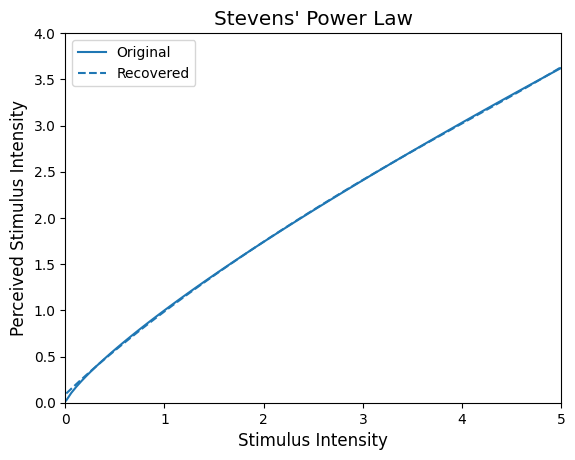

In [49]:
# run benchmark
benchmark(experiment_runner = stevens_power_law(), theorist = feature_theorist)

#### EXPERIMENT CONDITIONS (X):
            S1        S2
0     0.010000  0.010000
1     0.010000  0.060404
2     0.010000  0.110808
3     0.010000  0.161212
4     0.010000  0.211616
...        ...       ...
5045  4.899192  4.949596
5046  4.899192  5.000000
5047  4.949596  4.949596
5048  4.949596  5.000000
5049  5.000000  5.000000

[5050 rows x 2 columns]
#### EXPERIMENT OBSERVATIONS (Y):
      difference_detected
0               -0.008161
1                1.796910
2                2.407555
3                2.774278
4                3.041334
...                   ...
5045             0.018018
5046             0.024073
5047             0.000786
5048            -0.005015
5049            -0.007660

[5050 rows x 1 columns]
#### IDENTIFIED EQUATION:
y = 0.0018 + (-0.998)·ln(1+(S1−S2)/S2) + (0.000338)·S1^2 + (-3.66e-05)·S1^3 + (8.96e-06)·S1S2^2 + (-2.5e-05)·S2^3
#### VALIDATION SET MSE:
difference_detected    0.000105
dtype: float64


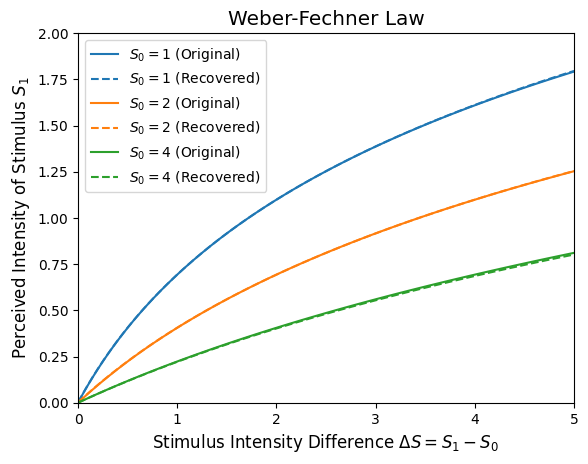

In [50]:
# run benchmark
benchmark(experiment_runner = weber_fechner_law(), theorist = feature_theorist)

#### EXPERIMENT CONDITIONS (X):
        V_A       P_A       V_B       P_B
0 -1.000000 -0.777778 -0.555556 -0.333333
1 -0.111111  0.111111  0.333333  0.555556
2  0.777778  1.000000  0.000000  0.111111
3  0.222222  0.333333  0.444444  0.555556
4  0.666667  0.777778  0.888889  1.000000
5 -1.000000 -0.777778 -0.555556 -0.333333
6 -0.111111  0.111111  0.333333  0.555556
7  0.777778  1.000000  0.000000  0.111111
8  0.222222  0.333333  0.444444  0.555556
9  0.666667  0.777778  0.888889  1.000000
#### EXPERIMENT OBSERVATIONS (Y):
   choose_A
0  0.941015
1  0.267010
2  0.982160
3  0.292459
4  0.117076
5  0.944800
6  0.333771
7  0.980950
8  0.372830
9  0.140492
#### IDENTIFIED EQUATION:
y = 0.458 + (0.771)·ΔEV + (-0.124)·ΔEV^2
#### VALIDATION SET MSE:
choose_A    0.003772
dtype: float64


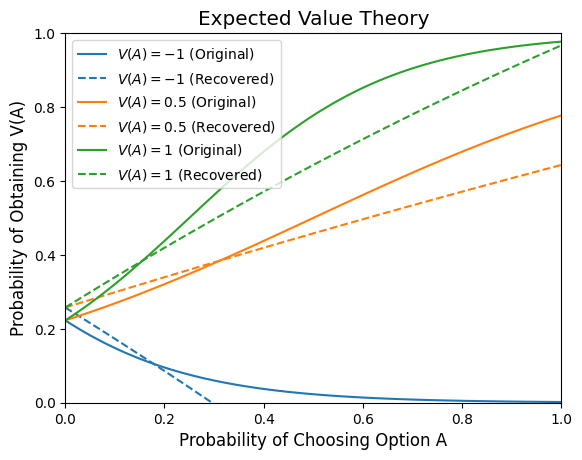

In [51]:
# run benchmark
benchmark(experiment_runner = expected_value_theory(), theorist = feature_theorist)

### Weber-Fechner-Law

The Weber-Fechner law quantifies the minimum change in a stimulus required to be noticeable. Similar to Steven's power law, the greater the intensity of a stimulus, the larger the change needed to be perceivable. This relationship is hypothesized to be proportional to the logarithm of the ratio between the two stimuli:

$\text{perceived intensity} = \log\left(\dfrac{S_1}{S_2}\right)$


where $S_1$ ($range: [0.01, 5.00]$) is the intensity of a physical stimulus (e.g., the luminosity of a lamp), $S_2$ ($range: [0.01, 5.00]$ ) is a reference stimulus (e.g., the luminosity of a background light), and $y$ is the perceived stimulus intensity (e.g. the perception of the lamp's luminosity).

In [ ]:
# run benchmark
benchmark(experiment_runner = weber_fechner_law(), theorist = baseline_theorist)

#### EXPERIMENT CONDITIONS (X):
            S1        S2
0     0.010000  0.010000
1     0.010000  0.060404
2     0.010000  0.110808
3     0.010000  0.161212
4     0.010000  0.211616
...        ...       ...
5045  4.899192  4.949596
5046  4.899192  5.000000
5047  4.949596  4.949596
5048  4.949596  5.000000
5049  5.000000  5.000000

[5050 rows x 2 columns]
#### EXPERIMENT OBSERVATIONS (Y):
      difference_detected
0               -0.019592
1                1.804491
2                2.406554
3                2.784106
4                3.051989
...                   ...
5045             0.012761
5046             0.011225
5047             0.007071
5048             0.029873
5049             0.002127

[5050 rows x 1 columns]


/tmp/ipykernel_7719/1246657047.py:20: RuntimeWarning: invalid value encountered in log
  A, B = np.polyfit(np.log(x[mask]), np.log(y[mask]), 1)


ValueError: Input contains NaN.

### Expected Utility Model with Two Choice Options

The expected utility model evaluates decision-making under uncertainty, quantifying the expected value of different choices based on their potential outcomes and associated probabilities. The model assumes that individuals aim to maximize their expected utility when faced with two options. Each option has a specific value and probability, influenced by a certain level of noise.

For two choice options, the expected value of each option is calculated as follows:

$$
E_A = V_A \times P_A
$$

$$
E_B = V_B \times P_B
$$

where:
- $V_A$ and $V_B$ represent the values of options A and B respectively.
- $P_A$ and $P_B$ represent the probabilities associated with these options.

The probability of choosing option A $P_{\text{choose}_A}$ is then determined using the softmax function, which considers the expected values of both options and a choice temperature parameter that influences the sensitivity to differences in expected values:

$$
P_{\text{choose}_A} = \frac{\exp(E_A / \beta)}{\exp(E_A / \beta) + \exp(E_B / \beta)}
$$

In this model:
- $\beta$ controls the degree of randomness in the choice, with higher values leading to more exploration and lower values leading to more deterministic choices based on the expected values.
- The softmax function ensures that the probabilities sum to 1, providing a normalized measure of the likelihood of choosing each option.

This model captures the influence of value, probability, and noise on decision-making, reflecting the complexity and variability of human choices under uncertainty.



In [7]:
# run benchmark
benchmark(experiment_runner = expected_value_theory(), theorist = current_theorist)

#### EXPERIMENT CONDITIONS (X):
        V_A       P_A       V_B       P_B
0 -1.000000 -0.777778 -0.555556 -0.333333
1 -0.111111  0.111111  0.333333  0.555556
2  0.777778  1.000000  0.000000  0.111111
3  0.222222  0.333333  0.444444  0.555556
4  0.666667  0.777778  0.888889  1.000000
5 -1.000000 -0.777778 -0.555556 -0.333333
6 -0.111111  0.111111  0.333333  0.555556
7  0.777778  1.000000  0.000000  0.111111
8  0.222222  0.333333  0.444444  0.555556
9  0.666667  0.777778  0.888889  1.000000
#### EXPERIMENT OBSERVATIONS (Y):
   choose_A
0  0.949637
1  0.277499
2  0.980477
3  0.308169
4  0.104147
5  0.953684
6  0.229651
7  0.981099
8  0.300716
9  0.148362


/tmp/ipykernel_7719/1246657047.py:21: RuntimeWarning: invalid value encountered in power
  y_pred = np.exp(A) * x**B


ValueError: Input contains NaN.